In [1]:
import pandas as pd
import random
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque  # Add this import
#!which python


# Some functions may not work for multiplexing (such as getPossibleStates)

In [2]:
class QuantumNetworks():
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, maxLinks, goalEdges):
        self.initialEdges = copy.deepcopy(initialEdges) 
        self.currentEdges = {} 
        self.pGen = pGen
        self.pSwap = pSwap
        self.cutOffAge = cutOffAge
        self.maxLinks = maxLinks
        self.goalEdges = goalEdges
        self.total_timesteps = 1
        # Extract unique nodes from initialEdges
        self.nodes = set(node for edge in initialEdges for node in edge)
        # Calculate max qubits per node
        self.maxQubits = {node: len([edge for edge in initialEdges if node in edge]) for node in self.nodes}
        self.goal_edge_counts = {edge: 1 for edge, _ in goalEdges}
    
    def reset(self) -> None:
        self.currentEdges = {}
    
    def getState(self) -> dict:
        return self.currentEdges
    
        
    def generateEntanglement(self, node1, node2): # Extend later to attemptGenerateEntanglements()
        edge = tuple(sorted([node1, node2]))
        if edge not in self.currentEdges:
            self.currentEdges[edge] = deque([0])
        else:
            if len(self.currentEdges[edge]) < self.maxLinks:
                self.currentEdges[edge].appendleft(0) # Retain order by age

    def probalisticallyGenerateEntanglements(self):
        for edge in self.initialEdges:
            if random.random() < self.pGen:
                self.generateEntanglement(*edge)
    
    def discardEntanglement(self, edge: tuple):
        try:
            self.currentEdges[edge].pop()
            if len(self.currentEdges[edge]) == 0:
                del self.currentEdges[edge]
        except KeyError:
            print(f"Edge {edge} not found in currentEdges, this is might be a problem.")
    
    def increaseGlobalEntanglementAge(self):
        for edge in list(self.currentEdges.keys()):  # Create a list to avoid modifying dict during iteration
            newAges = [age + 1 for age in self.currentEdges[edge] if age < self.cutOffAge]
            if not newAges:  # If no ages remain after filtering
                del self.currentEdges[edge]  # Remove the empty edge
            else:
                self.currentEdges[edge] = deque(newAges)
        
    def performSwapping(self, edge1: tuple, edge2: tuple = None):
        # Handle list of swaps
        if isinstance(edge1, list):
            for swap in edge1:
                self.performSwapping(swap[0], swap[1])
            return
                
        # Handle single tuple containing both edges
        if isinstance(edge1, tuple) and len(edge1) == 2 and edge2 is None:
            edge1, edge2 = edge1
        
        # Validate edges exist and have entanglements
        for edge in (edge1, edge2):
            if edge not in self.currentEdges:
                return
            if not self.currentEdges[edge]:
                return
        
        # Max Qubits
        # Check qubit capacity constraints
        # node_usage = collections.defaultdict(int)
        
        # # Count current qubit usage for each node
        # for edge, entanglements in self.currentEdges.items():
        #     for node in edge:
        #         node_usage[node] += len(entanglements)
        
        # # Check if nodes have enough qubits for the swap
        # nodes_involved = set(edge1 + edge2)
        # for node in nodes_involved:
        #     # Add +1 to account for the new link that will be created
        #     if node_usage[node] + 1 > self.maxQubits[node]:
        #         print(f"Node {node} exceeds maximum qubit capacity")
        #         return
        
        # Create new link from non-shared nodes
        combined_nodes = list(edge1) + list(edge2)
        newLink = tuple(sorted(node for node in combined_nodes 
                            if combined_nodes.count(node) == 1))
        
        # Calculate new age as maximum of consumed entanglement ages
        newAge = max(max(self.currentEdges[edge1]), 
                    max(self.currentEdges[edge2]))
        
        # Add new entanglement
        if newLink not in self.currentEdges:
            self.currentEdges[newLink] = deque([newAge])
        elif len(self.currentEdges[newLink]) < self.maxLinks:
            self.currentEdges[newLink].append(newAge)
            
        # Consume used entanglements
        self.discardEntanglement(edge1)
        self.discardEntanglement(edge2) 

    def calcReward(self, state):
        reward = 0
        for goal_edge, weight in self.goalEdges:
            if goal_edge in state:
                # Increment the count for this goal edge
                self.goal_edge_counts[goal_edge] += 1
                # Calculate EDR (Entanglement Distribution Rate)
                goal_edge_edr = self.goal_edge_counts[goal_edge] / self.total_timesteps
                reward += weight / goal_edge_edr
        self.total_timesteps += 1
        # Summation reward
        return log(reward)
    
    def isTerminal(self):
        for goal_edge, weight in self.goalEdges:
            if goal_edge in self.currentEdges:
                return True
        return False
    
    def getPossibleActionsAndCorrespondingStates(self) -> list:
        active_edges = [edge for edge, ages in self.currentEdges.items() if ages and min(ages) < self.cutOffAge - 1] 
        possible_swaps = []
        for edge1, edge2 in itertools.combinations(active_edges, 2):
            if set(edge1) & set(edge2):  # if edges share a node
                possible_swaps.append((edge1, edge2))
        
        # Modified to include states and their corresponding swap sequences
        possible_states_and_swaps = [(self.currentEdges, [])]  # (state, swap_sequence)
        
        # Consider sequential swaps up to a reasonable depth (e.g., 3)
        max_swap_depth = 3
        states_to_explore = [(copy.deepcopy(self.currentEdges), [])]
        
        for depth in range(max_swap_depth):
            next_states = []
            for current_state, swap_history in states_to_explore:
                # Find possible swaps in current state
                active_edges = [edge for edge, ages in current_state.items() if len(ages) > 0]
                current_possible_swaps = []
                for edge1, edge2 in itertools.combinations(active_edges, 2):
                    if set(edge1) & set(edge2):
                        current_possible_swaps.append((edge1, edge2))
                
                # Try each possible swap
                for swap in current_possible_swaps:
                    edge1, edge2 = swap
                    new_state = copy.deepcopy(current_state)
                    
                    # Perform the swap
                    combined_nodes = list(edge1) + list(edge2)
                    new_edge = tuple(sorted([n for n in combined_nodes 
                                        if combined_nodes.count(n) == 1]))
                    
                    # Remove old edges
                    new_state[edge1].pop()
                    new_state[edge2].pop()
                    if len(new_state[edge1]) == 0: del new_state[edge1]
                    if len(new_state[edge2]) == 0: del new_state[edge2]
                    
                    # Add new edge
                    if new_edge not in new_state:
                        new_state[new_edge] = deque([0])
                    else:
                        new_state[new_edge].appendleft(0)
                    
                    new_swap_history = swap_history + [swap]
                    next_states.append((new_state, new_swap_history))
                    possible_states_and_swaps.append((new_state, new_swap_history))
            
            states_to_explore = next_states
        
        return possible_states_and_swaps
                

In [3]:
def stateActionToKey(state, action=None): # For Q-learning
    state_tuple = tuple(sorted((edge, tuple(ages)) for edge, ages in state.items()))
    if action is None or action == []:
        return state_tuple
    if action: 
        action_tuple = tuple(sorted(tuple(sorted(edge_pair)) for edge_pair in action))
    else:
        action_tuple = None
    
    return (state_tuple, action_tuple)
        
def epsilonGreedyPolicy(Q, state, epsilon):
    possible_states_actions = network.getPossibleActionsAndCorrespondingStates()
    if random.random() < epsilon:
        return random.choice(possible_states_actions) if possible_states_actions else (state, None)
    
    else:
        max_q = float('-inf')
        best_state_action = (state, None)
        for state_action in possible_states_actions:
            state_action_key = stateActionToKey(state, state_action[1])
            q_value = Q[state_action_key]
            if q_value > max_q:
                max_q = q_value
                best_state_action = state_action
        if max_q == float('-inf'):  # If no actions found in Q-table
            return random.choice(possible_states_actions) if possible_states_actions else (state, None)
            
        return best_state_action

In [18]:
# Env Parameters
cutOffAge = 1
pSwap = 1
pGen= 0.7
maxLinks = 1 # Disable for now multiplexing ## Off for now
goalEdges = [((1,5), 0.3), ((1,6), 0.7)] # (user, weight)
initialEdges = [(1,3), (2,3), (3,4), (4,5), (4,6)]
random.seed(1)
network = QuantumNetworks(initialEdges, pGen, pSwap, cutOffAge, maxLinks, goalEdges)
Q = collections.defaultdict(lambda: random.uniform(0.0, 0.01))  # Optimistic initialization
n = 1
epsilon = 0.1 
gamma = 0.9
alpha = 0.8
numEpisodes = 5000
maxSteps = 400
Q = collections.defaultdict(lambda: random.uniform(0.001, 0.01)) 

episodeRewards = np.zeros(numEpisodes)  # was: episodeRewards = []
episodeLengths = np.zeros(numEpisodes)  # was: episodeLengths = []

for episode in range(numEpisodes):
    print(f"Episode {episode + 1} of {numEpisodes}")
    network.reset()
    network.probalisticallyGenerateEntanglements()
    
    # Changed: Simplified state/action initialization
    state = network.getState()  # was: states = [network.getState()]
    _, action = epsilonGreedyPolicy(Q, state, epsilon)  # was: next_state, action = epsilonGreedyPolicy(Q, states[0], epsilon)
    
    # Changed: Initialize lists after getting initial state/action
    states = [state]
    actions = [action]
    rewards = []
    
    T = float('inf')
    t = 0    
    # Changed: Simplified while condition
    print(network.goal_edge_counts)
    while t < T:  # was: while tau < (T-1)
        # Take action and observe next state and reward
        if t < T:
            if actions[t] is not None:
                network.performSwapping(actions[t])
            network.increaseGlobalEntanglementAge()
            network.probalisticallyGenerateEntanglements()
            
            next_state = network.getState()
            reward = network.calcReward(next_state)
            
            states.append(next_state)
            rewards.append(reward)
            
            # Changed: Combined terminal conditions and simplified action selection
            if network.isTerminal() or t >= maxSteps:  # Added maxSteps check
                T = t + 1
                
            else:
                _, next_action = epsilonGreedyPolicy(Q, next_state, epsilon)
                actions.append(next_action)
        
        # Calculate n-step return and update Q-value
        tau = t - n + 1
        if tau >= 0:
            # Changed: Simplified G calculation
            G = sum([gamma**(i - tau - 1) * rewards[i] 
                    for i in range(tau + 1, min(tau + n, T))])
            
            # Changed: Simplified Q-value update logic
            if tau + n < T:
                next_state_action = stateActionToKey(states[tau + n], actions[tau + n])
                G += gamma**n * Q[next_state_action]
            
            current_state_action = stateActionToKey(states[tau], actions[tau])
            Q[current_state_action] += alpha * (G - Q[current_state_action])
        
        t += 1
        
    # Changed: Use numpy array assignment instead of list indexing
    episodeRewards[episode] = sum(rewards)  
    episodeLengths[episode] = len(rewards)


            
    

Episode 1 of 5000
{(1, 5): 1, (1, 6): 1}
Episode 2 of 5000
{(1, 5): 1, (1, 6): 2}
Episode 3 of 5000
{(1, 5): 2, (1, 6): 2}
Episode 4 of 5000
{(1, 5): 3, (1, 6): 2}
Episode 5 of 5000
{(1, 5): 4, (1, 6): 2}
Episode 6 of 5000
{(1, 5): 4, (1, 6): 3}
Episode 7 of 5000
{(1, 5): 5, (1, 6): 3}
Episode 8 of 5000
{(1, 5): 6, (1, 6): 3}
Episode 9 of 5000
{(1, 5): 7, (1, 6): 3}
Episode 10 of 5000
{(1, 5): 7, (1, 6): 4}
Episode 11 of 5000
{(1, 5): 8, (1, 6): 4}
Episode 12 of 5000
{(1, 5): 8, (1, 6): 5}
Episode 13 of 5000
{(1, 5): 8, (1, 6): 6}
Episode 14 of 5000
{(1, 5): 9, (1, 6): 6}
Episode 15 of 5000
{(1, 5): 9, (1, 6): 7}
Episode 16 of 5000
{(1, 5): 10, (1, 6): 7}
Episode 17 of 5000
{(1, 5): 11, (1, 6): 7}
Episode 18 of 5000
{(1, 5): 11, (1, 6): 8}
Episode 19 of 5000
{(1, 5): 11, (1, 6): 9}
Episode 20 of 5000
{(1, 5): 12, (1, 6): 9}
Episode 21 of 5000
{(1, 5): 12, (1, 6): 10}
Episode 22 of 5000
{(1, 5): 13, (1, 6): 10}
Episode 23 of 5000
{(1, 5): 13, (1, 6): 11}
Episode 24 of 5000
{(1, 5): 13, 

In [19]:
sorted_Q = sorted(Q.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Q-values:")
for i, (state_action, value) in enumerate(sorted_Q[:10], 1):
    print(f"\n{i}. Q-value: {value}")
    print(f"   State-Action: {state_action}")
    
# Issue is that we are not updating the q-values with the correct reward function...
# Also, it seems we are running into an issue were our highest Q-values are when we already have the ideal state..
    # No insights into other actions
# N-step look ahead seems to be working.................

Top 10 Q-values:

1. Q-value: 0.009999928688424708
   State-Action: ((((1, 3), (0,)), ((1, 4), (1,)), ((2, 3), (0,)), ((3, 4), (0,)), ((4, 5), (0,)), ((4, 6), (0,))), (((1, 3), (1, 4)), ((2, 3), (3, 4)), ((2, 4), (4, 6))))

2. Q-value: 0.009999130666081477
   State-Action: ((((2, 4), (1,)), ((4, 5), (0,)), ((4, 6), (1,))), (((2, 4), (4, 6)),))

3. Q-value: 0.009998947087451734
   State-Action: ((((1, 3), (1,)), ((2, 3), (0,)), ((3, 4), (0,)), ((4, 5), (0,)), ((4, 6), (0,)), ((5, 6), (1,))), (((1, 3), (2, 3)), ((3, 4), (4, 6))))

4. Q-value: 0.00999754301402737
   State-Action: (((1, 3), (0,)), ((3, 4), (0,)), ((4, 5), (0,)), ((5, 6), (1,)))

5. Q-value: 0.009997383730639218
   State-Action: ((((1, 3), (1,)), ((2, 3), (0,)), ((2, 4), (1,)), ((3, 4), (0,)), ((4, 5), (0,)), ((4, 6), (1,))), (((1, 3), (2, 3)), ((2, 4), (4, 6)), ((3, 4), (4, 5))))

6. Q-value: 0.009997051795063185
   State-Action: ((((1, 2), (1,)), ((1, 3), (0,)), ((2, 3), (0,)), ((3, 5), (1,)), ((4, 5), (0,)), ((4, 6), (0,

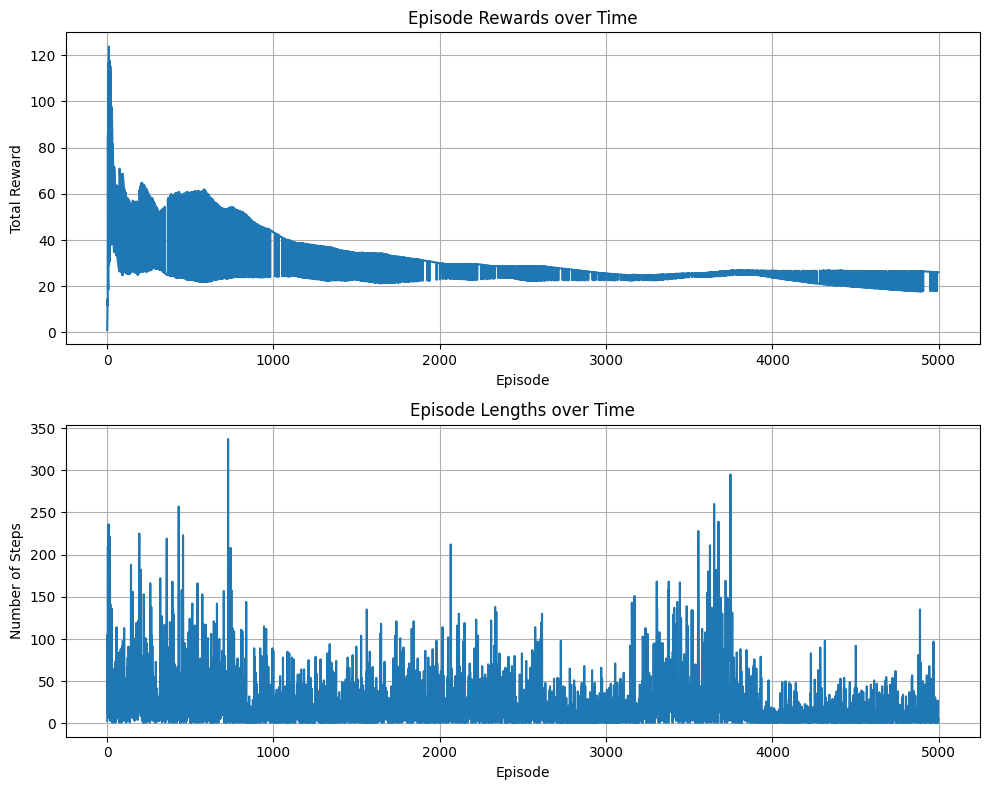

In [20]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot episode rewards
ax1.plot(range(numEpisodes), episodeRewards)
ax1.set_title('Episode Rewards over Time')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.grid(True)

# Plot episode lengths
ax2.plot(range(numEpisodes), episodeLengths)
ax2.set_title('Episode Lengths over Time')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Number of Steps')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()